# In this notebook, we show the steps taken to preprocess the **genes** expression data, generate and select features through feature selection strategies which include lasso, mrmr and the features from PAM50 and LIMMA50. After this, different models are tuned and evaluated in the classification task using training and test dataset.





USEFUL LINKS:

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

### Imports section: 


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
# uncomment to install libraries
! pip install mrmr_selection
! pip install scikit-learn==0.24.2 # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from pandas_profiling import ProfileReport
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
import mrmr
# select top K features using mRMR
from mrmr import mrmr_classif
import warnings
warnings.filterwarnings('ignore')

### Download of all datasets with different preprocessing strategies and feature spaces

In [ ]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/"
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/"

# Dataset with gene expression 
gene_dataset = pd.read_csv(path+"gene_expression_data_and_metadata/data_mrna_seq_v2_rsem.txt" , index_col= 0 , sep='\t') 
gene_dataset = gene_dataset.transpose() # (818, 20440)
# remove first column about entrez_gene_id
gene_dataset = gene_dataset.iloc[1: , :]
print(gene_dataset.shape)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train_test_new.xlsx", sheet_name="train_new")
testing_ds = pd.read_excel(path+"train_test_new.xlsx", sheet_name="test_new")

/content
(817, 20440)


In [ ]:
# feature spaces 
pam_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/PAM50.txt" , index_col= 0 , sep='\t') 
limma_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/LIMMA50.txt" , index_col= 0 , sep='\t') 

pam_fs.reset_index(inplace=True)
limma_fs.reset_index(inplace=True)

### create the cpm

In [ ]:
cpm_dataset_1 = gene_dataset.div(gene_dataset.sum(axis=1), axis=0)
cpm_dataset_end = cpm_dataset_1 * 1000000
cpm_dataset = cpm_dataset_end
cpm_dataset.shape

(817, 20440)

In [ ]:
cpm_dataset.columns.name = ''
cpm_dataset.index.rename('sample_id', inplace=True)
cpm_dataset.index = cpm_dataset.index.str[: -3] # removal of -01 from cpm sample id which is not relevant for recognition
cpm_dataset.head()

In [ ]:
# don't reset index since the sample ids have to be the indexes
# cpm_dataset.reset_index(inplace=True)

### filtering the genes that have expression data at the beginning lower than 4 for more than 80% of the samples.

In [ ]:
y = (gene_dataset[gene_dataset < 4].count() /818 > 0.8)
y = y[y==True]
y = y.reset_index()
print(y[''])

In [ ]:
gene_dataset.drop(y[''], axis=1, inplace=True)
gene_dataset.head()

In [ ]:
cpm_dataset.drop(y[''], axis=1, inplace=True)
cpm_dataset.head()

### Evaluation of the median values

In [ ]:
med = cpm_dataset.median()
med.sort_values(inplace=True)
md = pd.DataFrame(med)
md.describe()

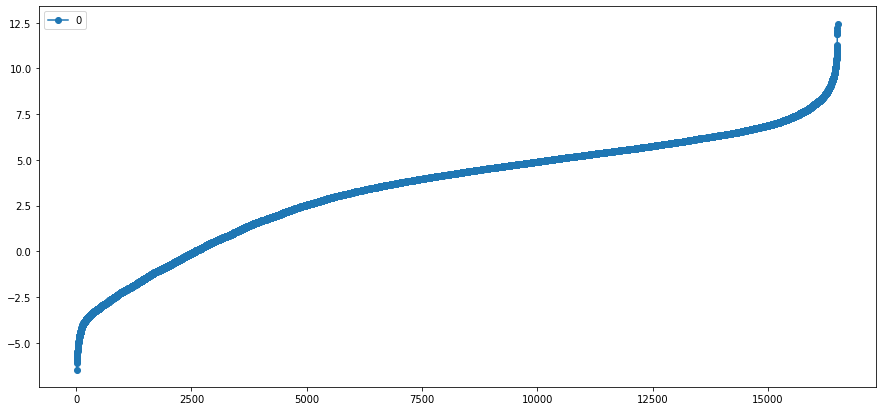

In [ ]:
%matplotlib inline
log_md = np.log2(md)
log_md.reset_index(drop=True).plot(figsize=(15,7), style='o-')

In [ ]:
md = md[md>3.38]
md.dropna(inplace=True)
gene_to_keep_by_median = md.index.tolist()
gene_to_keep_by_median

In [ ]:
len(np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median))


12381

In [ ]:
# keeping just the filtered by removing the ones with median value lower than the 25% from the describe
cpm_dataset = cpm_dataset[np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median)]

In [ ]:
cpm_dataset.head()

In [ ]:
cpm_dataset.shape

(817, 12385)

In [ ]:
def extract_and_reduce_by_columns(full_df, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = full_df # path of subdatset 
  full_list= full_df['Genes'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
    
  
  #data.reset_index(inplace=True) # todo remove
  #data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True) 
  # print("hello", data.index)
  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data.index.isin(x)]
  # print("hello11", data1)
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_label':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(main_filtered_gene_fs, training_ds, 'log2') 
X_train_pre_lasso = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_pre_lasso=train.subtype
print("X_train size:", X_train_pre_lasso.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(main_filtered_gene_fs, testing_ds,  'log2') 
X_test_pre_lasso = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pre_lasso = test.subtype
print("X_test size:", X_test_pre_lasso.shape)

X_train size: (410, 12385)
X_test size: (127, 12385)


DATASET with PAM50 Feature Space

In [ ]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'none') 
# print("aloha", train)
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam = train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds,'none' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 Feature Space

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'none' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'none') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET with PAM50 features and LOGE PREPROCESSING



In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'loge') 
X_train_pam_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_loge=train.subtype
print("X_train size:", X_train_pam_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'loge') 
X_test_pam_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_loge = test.subtype
print("X_test size:", X_test_pam_loge.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 features and LOGE PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'loge' ) 
X_train_limma_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_loge =train.subtype
print("X_train size:", X_train_limma_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'loge' ) 
X_test_limma_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_loge = test.subtype
print("X_test size:", X_test_limma_loge.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET with PAM50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'none') 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'log2') 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET with features selected throgh LASSO REGRESSION from PAM50 and LOG2 PREPROCESSING

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_pam_log2,Y_train_pam_log2)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
sel_.get_support()
selected_feat = X_train_pam_log2.columns[(sel_.get_support())]

In [ ]:
print('total features: {}'.format((X_train_pam_log2.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/131*5))

total features: 49
selected features: 48
Percentage features with coefficients shrank to zero: 4.0458015267175576


In [ ]:
X_train_pam_log2_sel = X_train_pam_log2[selected_feat].copy()
Y_train_pam_log2_sel = Y_train_pam_log2

X_test_pam_log2_sel = X_test_pam_log2[selected_feat].copy()
Y_test_pam_log2_sel = Y_test_pam_log2

DATASET with features selected throgh LASSO REGRESSION from LIMMA50 and LOG2 PREPROCESSING

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_limma_log2,Y_train_limma_log2)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
sel_.get_support()
selected_feat = X_train_limma_log2.columns[(sel_.get_support())]

In [ ]:
print('total features: {}'.format((X_train_limma_log2.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/557*5))

total features: 185
selected features: 91
Percentage features with coefficients shrank to zero: 7.136445242369839


In [ ]:
X_train_limma_log2_sel = X_train_limma_log2[selected_feat].copy()
Y_train_limma_log2_sel = Y_train_limma_log2

X_test_limma_log2_sel = X_test_limma_log2[selected_feat].copy()
Y_test_limma_log2_sel = Y_test_limma_log2

DATASET 9 CON FS NEW E LOG PREPROCESSING (choose best try 2 for now) 

In [ ]:
from scipy.optimize.optimize import main
main_filtered_gene_fs = pd.DataFrame({'Genes': cpm_dataset.columns.tolist()})

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_pre_lasso,Y_train_pre_lasso)
sel_.get_support()
selected_feat = X_train_pre_lasso.columns[(sel_.get_support())]
print(sel_.estimator_.coef_)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
print('total features: {}'.format((X_train_pre_lasso.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

perc_feat_selected = np.sum(sel_.estimator_.coef_ == 0)/ (12385*5)
print(perc_feat_selected)

total features: 12385
selected features: 1104
coefficients shrank to zero: 60452
0.976213161081954


In [ ]:
X_train_lasso = X_train_pre_lasso[selected_feat].copy()
Y_train_lasso = Y_train_pre_lasso

X_test_lasso = X_test_pre_lasso[selected_feat].copy()
Y_test_lasso = Y_test_pre_lasso

## MRMR

In [ ]:
mrmr_features = mrmr_classif(X=X_train_lasso, y=Y_train_lasso, K=750)

# Next steps: check how many of the chosen features overlap with selected with lasso, pam50 and limam50
# in other training notebook: check how the models perform on it 

100%|██████████| 750/750 [04:14<00:00,  2.95it/s]


In [ ]:
X_train_mrmr = X_train_lasso[mrmr_features].copy()
Y_train_mrmr = Y_train_lasso

X_test_mrmr = X_test_lasso[mrmr_features].copy()
Y_test_mrmr = Y_test_lasso

In [ ]:
print(X_train_mrmr.shape, X_test_mrmr.shape)

(410, 750) (127, 750)


### Model training, evaluation and saving of results


In [ ]:
# This functions shows the evaluation results for the entire test set and also the metrics for each single class

def show_single_class_evaluation(y_pred: int, y_test: int, labels):
  print("Balanced accuracy: ", round(balanced_accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print('precision ', round(precision_score(y_test, y_pred, average="macro"), 3))
  print('recall ', round(recall_score(y_test, y_pred, average="macro"), 3))
  print('f1_macro ', round(f1_score(y_test, y_pred, average="macro"),3))
  print('f1_micro ', round(f1_score(y_test, y_pred, average="micro"),3))
  print("Precision: ", [round(i, 3) for i in precision_score(y_test, y_pred, average=None) ])
  print("Recall: ",  [round(i, 3) for i in recall_score(y_test, y_pred, average=None) ]) 
  print("F1 Score: ", [round(i, 3) for i in f1_score(y_test, y_pred, average=None) ]) 
  print('--------------------------------------------')

  dic_result = {}
  dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_test, y_pred), 3)]
  dic_result['accuracy'] = [round(accuracy_score(y_test, y_pred), 3)]
  for i in range(len(labels)):
    dic_result[labels[i]+'-precision'] =  round( precision_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):
    dic_result[labels[i]+'-recall'] =  round( recall_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):   
    dic_result[labels[i]+'-f1_score'] =  round( f1_score(y_test, y_pred, average=None)[i], 3)
  
  df_result = pd.DataFrame.from_dict(dic_result)
  df_result.to_excel('output_detailed_scores.xlsx')
  print(df_result)

In [ ]:
Y_train_limma_log2.to_csv("test")

In [ ]:
def write_results(results, final_path, name_file):
      '''
      Function to write results metrics and confing into a csv file with as name the current date
      '''
      
      # datetime object containing current date and time
      now = datetime.now()
      dt_string = now.strftime("%d%m%Y%H%M%S")
      dt = now.strftime("%d%m%Y")

      if not os.path.exists(results_path+'genes/'+final_path+dt+'/'):
        os.mkdir(results_path+'genes/'+final_path+dt+'/')

      
      df = pd.DataFrame(results)
      # add gene as directory
      df.to_csv(results_path+'genes/'+final_path+dt+'/'+name_file+dt_string+".csv")

In [ ]:
def training_and_saving_after_cv_and_single_split(which_ds, X_train, Y_train,X_test, Y_test, scores, param_values, model):

  C = []
  l1_ratio = []
  cv_best = []
  score_test_balanced_accuracy = []
  score_test_accuracy = []
  precision = []
  recall = []
  f1=[]

  for index, score in enumerate(scores):
      # -------RESULTS in CROSS_VALIDATION-----------
      print("Tuning hyper-parameters for %s" % score)
      # Fit and hyperparameter search
      selected_model = GridSearchCV(model(), param_values, scoring=score, cv=10)
      selected_model.fit(X_train, Y_train)
      # found best model and fit on training
      print("Parameter setting that gave the best results on the hold out data: ",  selected_model.best_params_)
      print("Mean cross-validated score of the best_estimator found, mean, std dev: ",  selected_model.best_score_, selected_model.cv_results_['mean_test_score'], selected_model.cv_results_['std_test_score'] )

      # save top config and score from grid search (only accuracy or balanced accuracy)
      # evaltype datasetdetails modelname parameters balancedaccuracy
      dic_result = {}
      dic_result['eval_type']= ['GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['name_score']= [score]
      dic_result['best_score'] = [selected_model.best_score_]
      dic_result['mean_test_score'] = [selected_model.best_score_]
      index, = np.where(selected_model.cv_results_['mean_test_score']==selected_model.best_score_)
      dic_result['std_test_score'] =selected_model.cv_results_['std_test_score'][index[0]]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results: ', df_result)
      write_results(df_result,model.__name__ +'/', 'cv_on_'+score)

      # use top config and trained model for evaluation on test
      y_true, y_pred = Y_test, selected_model.predict(X_test)

      # save results from test
      # evaltype datasetdetails modelname parameters balacc accc prec rec f1
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1_macro'] = [round(f1_score(y_true, y_pred, average="macro"),3)]
      dic_result['f1_micro'] = [round(f1_score(y_true, y_pred, average="micro"),3)]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results on test eval: ', df_result)
      # not saved anymore because the results are the same as creating new model and performing eval on test set
      # it was initiially introduced for verification
      # write_results(df_result,model.__name__ +'/', 'testcv_on_'+score) 

      # create new model with top convig and evaluate for verification
      check_model = model(**selected_model.best_params_)
      check_model.fit(X_train, Y_train)
      
      y_true, y_pred = Y_test, check_model.predict(X_test)

      # save again the scores
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1_macro'] = [round(f1_score(y_true, y_pred, average="macro"),3)]
      dic_result['f1_micro'] = [round(f1_score(y_true, y_pred, average="micro"),3)]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Results on test eval: ', df_result)
      write_results(df_result,model.__name__ +'/', 'test_on_'+score)

### Running section

In [ ]:
# for each dataset
# for each model
# create all parameters and other details to pass to the fun
# run training and saving function 

Parameters spaces definition

In [ ]:
# Configuration of parameters and name

#GridSearch attributes
# Set the parameters by cross-validation
#'l1_ratio':[0.5], 'solver': ['saga'], 'penalty':['elasticnet']
logreg_tuned_parameters = [{
    'multi_class':  ['ovr'],
    'penalty':['elasticnet'],
    'solver': ['saga'], 
    'max_iter':[2000], 
    'C':  [ 0.001, 0.01], #[10 ** i for i in range(-2,1)],
    'l1_ratio': [ 0.01, 0.001] #[10 ** i for i in range(-2,1)] #'l1_ratio':[0.5]}]
    }]

svc_tuned_parameters = [{
    'kernel':['poly'], 
    'degree': [1, 2, 3], 
    'gamma': [10 ** i for i in range(-3,3)],
    'max_iter':[1000], 
    'C': [ 0.001, 0.01]}]

scores = [  "balanced_accuracy"]

print(logreg_tuned_parameters)
print(svc_tuned_parameters)

[{'multi_class': ['ovr'], 'penalty': ['elasticnet'], 'solver': ['saga'], 'max_iter': [2000], 'C': [0.001, 0.01], 'l1_ratio': [0.01, 0.001]}]
[{'kernel': ['poly'], 'degree': [1, 2, 3], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000], 'C': [0.001, 0.01]}]


dataset 1 with fs pam50

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores, svc_tuned_parameters, SVC)

dataset 2 with fs limma50

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, svc_tuned_parameters, SVC)

dataset 3 with fs pam50 and loge preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, svc_tuned_parameters, SVC)

dataset 4 with fs limma50 and loge preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, svc_tuned_parameters, SVC)

dataset 5 with fs pam50 and log2 preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, svc_tuned_parameters, SVC)

dataset 6 with fs limma50 and log2 preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, logreg_tuned_parameters, LogisticRegression)


# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, svc_tuned_parameters, SVC)

DATASET 7 CON FS REDUCED FROM PAM50 E LOG PREPROCESSING (choose the best between 2 and e)



In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_log2_sel, Y_train_pam_log2_sel, X_test_pam_log2_sel, Y_test_pam_log2_sel, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_log2_sel, Y_train_pam_log2_sel, X_test_pam_log2_sel, Y_test_pam_log2_sel, scores, svc_tuned_parameters, SVC)

DATASET 8 CON FS REDUCED FROM LIMMA50 E LOG PREPROCESSING (choose the best between 2 and e)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_log2_sel, Y_train_limma_log2_sel, X_test_limma_log2_sel, Y_test_limma_log2_sel, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC

training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_log2_sel, Y_train_limma_log2_sel, X_test_limma_log2_sel, Y_test_limma_log2_sel, scores, svc_tuned_parameters, SVC)

DATASET 9 CON FS NEW E LOG PREPROCESSING (choose best try e for now)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, svc_tuned_parameters, SVC)

DATASET 10 CON FS NEW with mrmr for feature space E LOG PREPROCESSING (choose best try e for now)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mnrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, svc_tuned_parameters, SVC)

### Linear SVC tuning and testing

dataset 1 with fs pam50

In [ ]:
lin_svc_tuned_parameters = [{
    #'kernel':['linear'],  
    # 'degree': [1, 2, 3], # 1 for linear, 2 for polynomial
    'penalty' : ['l1', 'l2'],
    'max_iter':[1000], 
    'C': [10 ** i for i in range(-3,3)]
    }]

In [ ]:
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores, lin_svc_tuned_parameters, LinearSVC)

dataset 2 with fs limma50

In [ ]:

training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, lin_svc_tuned_parameters, LinearSVC)

dataset 3 with fs pam50 and loge preprocessing

In [ ]:

training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, lin_svc_tuned_parameters, LinearSVC)

dataset 4 with fs limma50 and loge preprocessing

In [ ]:

training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, lin_svc_tuned_parameters, LinearSVC)

dataset 5 with fs pam50 and log2 preprocessing

In [ ]:

training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores,lin_svc_tuned_parameters, LinearSVC)

dataset 6 with fs limma50 and log2 preprocessing

In [ ]:

training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, lin_svc_tuned_parameters, LinearSVC)

DATASET 7 CON FS REDUCED FROM PAM50 E LOG PREPROCESSING (choose the best between 2 and e)



In [ ]:

training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_log2_sel, Y_train_pam_log2_sel, X_test_pam_log2_sel, Y_test_pam_log2_sel, scores, lin_svc_tuned_parameters, LinearSVC)

DATASET 8 CON FS REDUCED FROM LIMMA50 E LOG PREPROCESSING (choose the best between 2 and e)

In [ ]:

training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_log2_sel, Y_train_limma_log2_sel, X_test_limma_log2_sel, Y_test_limma_log2_sel, scores, lin_svc_tuned_parameters, LinearSVC)

DATASET 9 CON FS NEW E LOG PREPROCESSING (choose best try e for now)

In [ ]:

training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, lin_svc_tuned_parameters, LinearSVC)

DATASET 10 CON FS NEW with mrmr for feature space E LOG PREPROCESSING (choose best try e for now)

In [ ]:

training_and_saving_after_cv_and_single_split('mnrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, lin_svc_tuned_parameters, LinearSVC)

### Random Forest Classifier exploration

In [ ]:
# EVALUATION with RandomForrest
from sklearn.ensemble import RandomForestClassifier
rf_values= [{
    'criterion': ['gini', 'log_loss'],
    'min_samples_split': [5,10],
    'bootstrap': [ False],
    'max_depth': [ 100, None],
    'max_features': [ 'sqrt'],
    'min_samples_leaf': [1, 2],
    'n_estimators': [200, 600]
    }]



In [ ]:
# dataset 1
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores,rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 2
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 3
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 4
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 5
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 6
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 7
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_log2_sel, Y_train_pam_log2_sel, X_test_pam_log2_sel, Y_test_pam_log2_sel, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 8
training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_log2_sel, Y_train_limma_log2_sel, X_test_limma_log2_sel, Y_test_limma_log2_sel, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 9
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 10
training_and_saving_after_cv_and_single_split('mrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, rf_values,model=RandomForestClassifier)